<a href="https://colab.research.google.com/github/AndrewDavidRatnam/HandsonWorkingML/blob/main/Sequences_with_RNNs_and_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMports and STUFFs

In [1]:
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

if not (tf.config.list_physical_devices('TPU') or tf.config.list_physical_devices('GPU') ):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
if tf.config.list_physical_devices("TPU"):
  print("LEZZZZZZ GOOOO  TPU") #ALL GOOD
else:
  print("Using GPU")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.
Using GPU


## Sketch RNN Dataset

In [2]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 18s 0us/step


In [3]:
#creating paths for training tf records and eval(val and test) tf records
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")] )
eval_files = sorted(
    [ str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")] )

In [4]:
len(train_files), len(eval_files)

(10, 10)

In [5]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
  test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
  train_classes = train_classes_file.readlines()

assert train_classes == test_classes, "Something went wrong with data loading or reading data"

class_names = [name.strip().lower() for name in train_classes]

In [6]:
sorted(class_names)[::10]

['aircraft carrier',
 'asparagus',
 'bat',
 'binoculars',
 'brain',
 'cactus',
 'canoe',
 'church',
 'couch',
 'diving board',
 'dumbbell',
 'feather',
 'floor lamp',
 'goatee',
 'headphones',
 'hot dog',
 'key',
 'lighter',
 'marker',
 'mountain',
 'octagon',
 'paper clip',
 'pickup truck',
 'popsicle',
 'rake',
 'saxophone',
 'shorts',
 'snorkel',
 'squiggle',
 'strawberry',
 'syringe',
 'the great wall of china',
 'tractor',
 'van',
 'wine glass']

In [7]:
@tf.function
def parse(data_batch):
  feature_descriptions = {
      "ink" : tf.io.VarLenFeature(dtype=tf.float32),
      "shape" : tf.io.FixedLenFeature([2], dtype=tf.int64),
      "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples["ink"])
  sketches = tf.reshape(flat_sketches, shape= [tf.size(data_batch), -1, 3])
  lengths = examples["shape"][:, 0]
  labels = examples["class_index"][:, 0]
  return sketches, lengths, labels



In [8]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=tf.data.AUTOTUNE)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
  return dataset.prefetch(tf.data.AUTOTUNE)



In [9]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10_000)
val_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

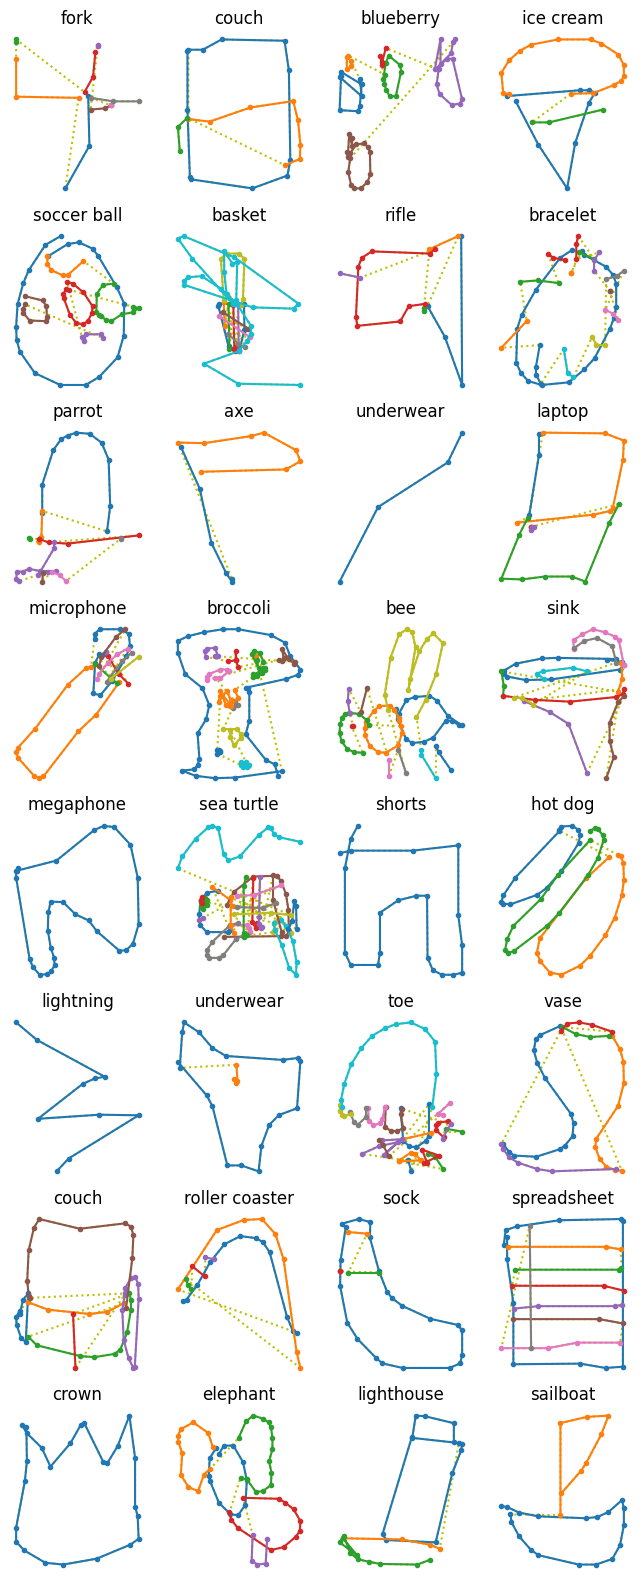

In [10]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    ##Origin Point: The origin point [0., 0., 0.] is added to the beginning of the sketch array. This ensures the sketch starts from the origin.

    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    #Find Stroke Ends: Identify the indices where a stroke ends, indicated by the value 1.0 in the last column.

    coordinates = sketch[:, :2].cumsum(axis=0)
    #Cumulative Sum: Calculate the cumulative sum of the coordinates. This converts relative movements into absolute positions.

    strokes = np.split(coordinates, stroke_end_indices + 1)
    #Split Strokes: Split the coordinates array into individual strokes based on the end indices.

    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    #Plot Sketch: Plot the entire sketch as a dotted yellow line, and then plot each stroke as a solid line.
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 2, n_rows * 2.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

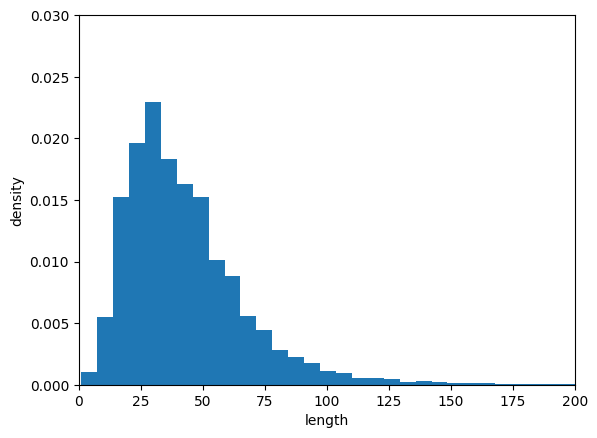

In [11]:
#visulazing the number of points
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [12]:
def crop_long_sketches(dataset, max_length=100):
  return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(val_set)
cropped_test_set = crop_long_sketches(test_set)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(), #RNN lol ?
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "sparse_top_k_categorical_accuracy"])


In [17]:
history = model.fit(cropped_train_set, epochs=10, validation_data=cropped_valid_set)

Epoch 1/10
  59455/Unknown - 3273s 55ms/step - loss: 2.5906 - accuracy: 0.4036 - sparse_top_k_categorical_accuracy: 0.6789

KeyboardInterrupt: 

In [40]:
y_test = np.concatenate([labels for _, _, labels in test_set.take(100)])
y_probas = model.predict(test_set.take(100))

100/100 [==============================] - 2s 17ms/step


In [43]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.773125

1/1 [==============================] - 0s 136ms/step


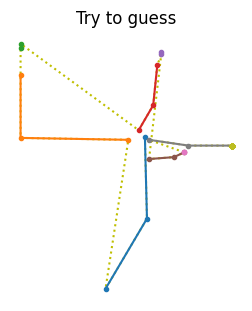

Top-5 predictions:
 1. snowflake 32.775%
 2. fork 18.178%
 3. feather 14.954%
 4. floor lamp 4.238%
 5. stitches 3.585%
Answer : fork


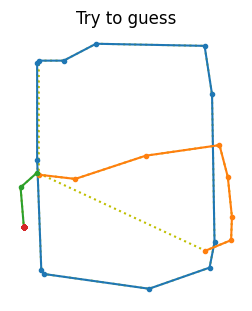

Top-5 predictions:
 1. barn 18.176%
 2. house 18.088%
 3. dishwasher 17.387%
 4. cooler 15.207%
 5. oven 4.321%
Answer : couch


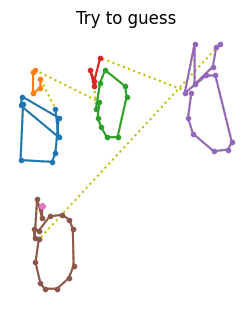

Top-5 predictions:
 1. peas 38.378%
 2. animal migration 14.865%
 3. rain 4.401%
 4. drums 3.502%
 5. string bean 3.378%
Answer : blueberry


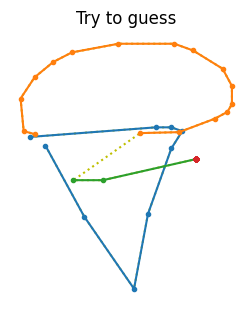

Top-5 predictions:
 1. ice cream 95.042%
 2. microphone 1.185%
 3. mushroom 0.672%
 4. diamond 0.650%
 5. nail 0.556%
Answer : ice cream


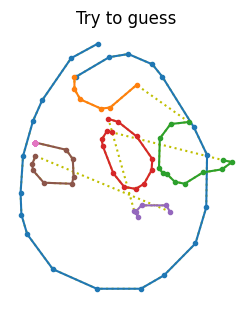

Top-5 predictions:
 1. face 19.881%
 2. soccer ball 12.506%
 3. moon 10.911%
 4. cookie 10.105%
 5. peas 7.739%
Answer : soccer ball


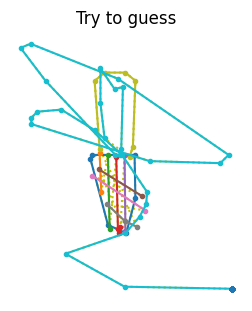

Top-5 predictions:
 1. rake 6.168%
 2. mosquito 3.771%
 3. trombone 3.079%
 4. beach 2.571%
 5. animal migration 2.287%
Answer : basket


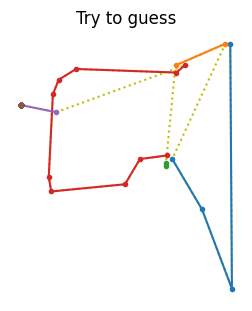

Top-5 predictions:
 1. snowflake 20.134%
 2. rifle 15.260%
 3. megaphone 10.436%
 4. clarinet 6.518%
 5. trumpet 5.829%
Answer : rifle


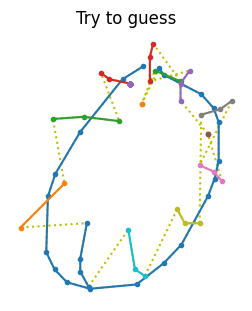

Top-5 predictions:
 1. bracelet 26.828%
 2. sun 25.421%
 3. alarm clock 8.537%
 4. hedgehog 8.347%
 5. clock 6.461%
Answer : bracelet


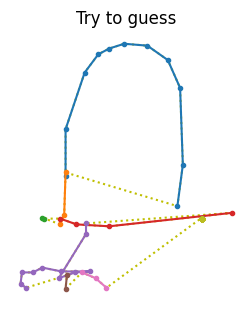

Top-5 predictions:
 1. toe 22.447%
 2. finger 10.450%
 3. rake 9.098%
 4. helmet 6.814%
 5. hat 5.851%
Answer : parrot


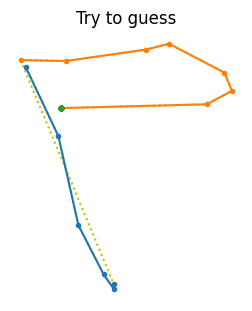

Top-5 predictions:
 1. streetlight 71.253%
 2. nail 7.477%
 3. matches 5.536%
 4. mailbox 3.709%
 5. axe 2.398%
Answer : axe


In [47]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
  plt.figure(figsize=(3, 3.5))
  draw_sketch(sketches[index])
  plt.show()
  print("Top-5 predictions:".format(index + 1))
  for k in range(5):
    class_name = class_names[top_k.indices[index, k]]
    proba = 100 * top_k.values[index, k]
    print(" {}. {} {:.3f}%".format(k+1, class_name, proba))
  print("Answer : {}".format(class_names[labels[index].numpy()]))

## Bach Chorales

In [48]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

117793/117793 [==============================] - 0s 0us/step


'./datasets/jsb_chorales.tgz'

In [63]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [64]:
import pandas as pd

def load_chorales(filepaths):
  return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [67]:
train_chorales[0][:2] #first song, first 2 bars or chords

[[74, 70, 65, 58], [74, 70, 65, 58]]

In [68]:
#coding up a synthesizer because authors wanted to have a bit of fun, me too my guy
# simple ways to do this using Midi Players among a few

from IPython.display import Audio
def notes_to_frequencies(notes):
  return 2**((np.array(notes) -69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
  note_duration = 60 / tempo #tempo is measured in bpm

  # to reduce click sound at every beat, we round the frequencies to try to
  #  get the samples close to zero at the end of each note.

  frequencies = (note_duration * frequencies).round() / note_duration
  n_samples = int(note_duration * sample_rate)
  time = np.linspace(0, note_duration, n_samples)
  sine_waves = np.sin(2*np.pi * frequencies.reshape(-1, 1) *time)

  sine_waves *= (frequencies > 9.).reshape(-1, 1) # removing notes with frequencies less than 9Hz
  return sine_waves.reshape(-1)

def chords_to_samples():
  pass